In [ ]:
!pip install jaxopt
!pip install ott-jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 153 kB 5.9 MB/s 
     |████████████████████████████████| 180 kB 46.8 MB/s 
     |████████████████████████████████| 596 kB 42.6 MB/s 
     |████████████████████████████████| 145 kB 45.9 MB/s 
     |████████████████████████████████| 217 kB 46.4 MB/s 
     |████████████████████████████████| 1.0 MB 2.3 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 2.2 MB/s 
  Created wheel for jax: filename=jax-0.3.16-py3-none-any.whl size=1197715 sha256=dce45423b77df66490f1c15f879d57984d2ba305e8e3906e5f2c7ca9e51bdb18
  Stored in directory: /root/.cache/pip/wheels/b9/0d/a2/2091279bf29b90a2211a271f6f006ef13a656211a9e69ba1e3
Successfully built jax
  Attempti

In [ ]:
import jax
from jax.scipy.sparse.linalg import gmres
from jax.lax import custom_linear_solve
from jax.numpy.linalg import slogdet
import jax.numpy as jnp

In [ ]:
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

## GP Process Regression

In [ ]:
def gp_regression_likelihood(Kxx, y, lbda):
  """ Compute Gaussian Process regression.
  
  Source: https://math.stackexchange.com/questions/1030534/gradients-of-marginal-likelihood-of-gaussian-process-with-squared-exponential-co

  -0.5 log det (K) - 0.5 y^t K_inv y - N/2 log 2pi
  with K_inv = K^{-1}
  
  Consistency of K required to ensure the inverse exists.  
  """
  # data fitting term
  tol = 1e-7
  maxiter = 5000

  def matvec_Kxx(b):
    return jnp.dot(Kxx, b) + (lbda**2)*b
  
  def solver_fun(matvec, b):
    return jax.scipy.sparse.linalg.cg(matvec, b, tol=tol, maxiter=maxiter)[0]
  
  K_inv_y = custom_linear_solve(matvec_Kxx, y, solve=solver_fun, symmetric=True)
  y_K_inv_y = - 0.5 * jnp.dot(y, K_inv_y)

  # cste : play no role in optimization
  N = y.shape[0]
  cste = - 0.5 * N * jnp.log(2 * jnp.pi)

  # regularization
  # derivative: https://github.com/google/jax/blob/de464fcf22c8bf7a2931182f8095bc01530df9fe/jax/_src/numpy/linalg.py#L190
  sign, log_abs_det = slogdet(Kxx + + (lbda**2)*jnp.eye(len(Kxx))) 
  log_det_value = - 0.5 * log_abs_det
  
  log_marginal_likelihood = log_det_value + y_K_inv_y + cste
  return log_marginal_likelihood

In [ ]:
# Based on https://arxiv.org/pdf/2009.10862.pdf
# "An Intuitive Tutorial to Gaussian Processes Regression"

def gp_process_prediction(kernel_fun, kernel_params, X_train, X_test, Y_train, lbda):
  """Cheap implementation of GP prediction based on Kernel matrix inverse."""
  X = jnp.concatenate([X_train, X_test], axis=0)
  K = kernel_fun(X, kernel_params)
  train_sl = slice(None, len(X_train), None)
  test_sl = slice(len(X_train), None, None)

  Kxx = K[train_sl,train_sl] + (lbda**2)*jnp.eye(len(X_train))
  inv_Kxx = jnp.linalg.inv(Kxx)
  Kzx = K[test_sl,train_sl]
  
  Y_pred = Kzx @ (inv_Kxx @ Y_train)
  Y_covar = K[test_sl,test_sl] - Kzx @ inv_Kxx @ Kzx.T
  Y_var = jnp.diag(Y_covar)
  return Y_pred, Y_var

In [ ]:
from jaxopt import OptaxSolver, LBFGS
import optax
from jaxopt.tree_util import tree_map, tree_sum, tree_sub, tree_scalar_mul, tree_add

def log_barrier(params, bounds):
  l_bounds, u_bounds = bounds
  clipped = tree_map(jnp.clip, params, l_bounds, u_bounds)
  eps_leaves = tree_scalar_mul(1e-3, tree_sub(u_bounds, l_bounds))
  l_loss = tree_map(lambda leaf, l, eps: jnp.log(leaf - l + eps), clipped, l_bounds, eps_leaves)
  u_loss = tree_map(lambda leaf, u, eps: jnp.log(u - leaf + eps), clipped, u_bounds, eps_leaves)
  loss = tree_sum(tree_add(l_loss, u_loss))
  return loss


def optimize_gpr(kernel_fun, log_bounds, X_train, X_test, y_train, y_test, lbda,
                 maxiter=1000, tol=1e-3, projected=False, verbose=False):
  bounds = tuple(map(lambda d: {('log_'+k):jnp.log(v) for k, v in d.items()}, log_bounds))
  kernel_params = kernel_fun.init_log_params()

  def gpr_step(kernel_params):
    if projected:
      kernel_params = tree_map(jnp.clip, kernel_params, bounds[0], bounds[1])
    Kxx = kernel_fun(X_train, kernel_params)
    loss = -gp_regression_likelihood(Kxx, y_train, lbda)
    return loss, Kxx

  # optax_opt = optax.sgd(learning_rate=1e-2)
  # opt = OptaxSolver(fun=gpr_step, opt=optax_opt, has_aux=True, maxiter=maxiter, tol=tol)
  opt = LBFGS(fun=gpr_step, has_aux=True, maxiter=maxiter, tol=tol, maxls=20)
  
  if verbose:

    state = opt.init_state(kernel_params)

    @jax.jit
    def opt_update(kernel_params, state):
      return opt.update(kernel_params, state)

    for step in range(maxiter):
      kernel_params, state = opt_update(kernel_params, state)
      if projected:
        kernel_params = tree_map(jnp.clip, kernel_params, bounds[0], bounds[1])
      Kxx = state.aux
      preds, _ = gp_process_prediction(kernel_fun, kernel_params, X_train, X_test, y_train, lbda)
      mse = jnp.mean((preds - y_test)**2)
      print_params = {k: f"{v:.3f}" for k, v in kernel_fun.get_params(kernel_params).items()}
      print(f"[{step+1}] error={state.error:.3f} mse={mse:.3f} loss={state.value:.3f} params={print_params} CondNumber={jnp.linalg.cond(Kxx)}")

  else:
    kernel_params, state = opt.run(kernel_params)
    Kxx = state.aux
    preds, _ = gp_process_prediction(kernel_fun, kernel_params, X_train, X_test, y_train, lbda)
    mse = jnp.mean((preds - y_test)**2)
    print_params = {k: f"{v:.3f}" for k, v in kernel_fun.get_params(kernel_params).items()}
    print(f"[{state.iter_num}] error={state.error:.3f} mse={mse:.3f} loss={state.value:.3f} params={print_params} CondNumber={jnp.linalg.cond(Kxx)}")

  return kernel_params

## Kernels

In [ ]:
from os import X_OK
from dataclasses import dataclass


@dataclass
class RBF_Kernel:
  """ RBF Kernel class.

  Attributes:
    gamma: nature of gamma scaling (default: 'scale').
      Mimic sklearn.svm.SVC behavior.
      'scale': 1 / (X.var() * n_features)
      'auto' : default value of 1
  """
  gamma: str = 'scale'

  def __post_init__(self):
    if self.gamma not in ['auto', 'scale']:
      raise ValueError(f"Unrecognized value {self.gamma} for gamma")

  def init_log_params(self):
    theta = jnp.array(0.)
    inv_sigma = jnp.array(0.)
    return {'log_theta': theta, 'log_sigma': inv_sigma}

  def get_params(self, log_params):
    return {k[len('log_'):]:jnp.exp(v) for k,v in log_params.items()}

  def _set_diag_1(self, m):
    i, j = jnp.diag_indices(len(m))
    m = m.at[i,j].set(1.)
    return m

  def __call__(self, X, kernel_params):
    if self.gamma == 'scale':
      scale = jnp.var(X) * X.shape[1]  # sklearn.SVC behavior
    elif self.gamma == 'auto':
      scale = 1.
    X = X / jnp.exp(kernel_params['log_sigma'])
    energy = jnp.sum((X[:,jnp.newaxis,:] - X[jnp.newaxis,:,:])**2, axis=-1)
    gamma = 0.5 / scale
    K = jnp.exp(-energy * gamma)
    K = self._set_diag_1(K)
    K_scalar = (jnp.exp(kernel_params['log_theta'])**2) * K
    return K_scalar

## GP regression tests

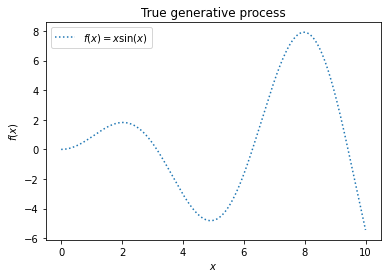

In [ ]:
import numpy as onp
import matplotlib.pyplot as plt

X = onp.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = onp.squeeze(X * onp.sin(X))
# y = (y - y.mean()) / y.std()

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [ ]:
rng = onp.random.RandomState(1)
training_indices = rng.choice(onp.arange(y.size), size=20, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

sk_kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
print('Condition number:', jnp.linalg.cond(gaussian_process.kernel_(X_train)))
print('Params:', gaussian_process.kernel_)
onp.set_printoptions(precision=6)
if len(X_train) <= 10:
  print('Kernel:', gaussian_process.kernel_(X_train))
onp.set_printoptions(precision=4)
print('Log Marginal Likelihood:', gaussian_process.log_marginal_likelihood_value_)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Condition number: 3.915460289332299e+17
Params: 28.9**2 * RBF(length_scale=3.05)
Log Marginal Likelihood: 67.04874239268894


In [ ]:
kernel = RBF_Kernel(gamma='scale')
lbda = 0.05**0.5
log_bounds = {'theta': jnp.array(1e-2), 'sigma': jnp.array(1e-1)}, {'theta': jnp.array(1e1), 'sigma': jnp.array(1e2)}
kernel_params = optimize_gpr(kernel, log_bounds, X_train, X, y_train, y, lbda=lbda, maxiter=100, verbose=True, projected=True)

[1] error=0.000 mse=4.422 loss=54.722 params={'sigma': '0.100', 'theta': '10.000'} CondNumber=9.380591633761729e+18


KeyboardInterrupt: ignored

In [ ]:
Kxx = kernel(X_train, kernel_params)
print('Condition number:', jnp.linalg.cond(Kxx))
print('Params:', kernel_params)
onp.set_printoptions(precision=6)
if len(Kxx) <= 10:
  print('Kernel:', Kxx)
onp.set_printoptions(precision=4)
print('[JAX    ] Log Marginal Likelihood:', gp_regression_likelihood(Kxx, y_train, lbda=lbda))
print('[SKLEARN] Log Marginal Likelihood:', gp_regression_likelihood(gaussian_process.kernel_(X_train), y_train, lbda=lbda))
delta = jnp.abs(gaussian_process.kernel_(X_train) - Kxx) / gaussian_process.kernel_(X_train)
print(f"Max Rel Error={jnp.max(delta)*100:.2f}%")

In [ ]:
mean_prediction, var_prediction = gp_process_prediction(kernel, kernel_params, X_train, X, y_train, lbda=lbda)
std_prediction = var_prediction ** 0.5

In [ ]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

## Sinkhorn Mu-GP

In [ ]:
from typing import Any, Optional
from dataclasses import dataclass

from jaxopt.tree_util import tree_l2_norm

from ott.geometry import pointcloud
import ott.core.sinkhorn as sinkhorn


@dataclass
class SinkhornMuGPR:
  """ Gaussian Process Regression with Sinkhorn Mu Kernel.

  Attributes:
    sinkhorn_epsilon: (float) regularization in Sinkhorn. Default: 1e-2.
    kernel_fun: function that takes an array of shape (n, f) and return an array of shape (n, n)
      kernel_fun(x)_ij = K(x_i, x_j) is the covariance matrix of the GP.
    log_bounds bounds for Kernel parmateres
  """
  maxiter: int = 1000
  tol: float = 1e-3
  sinkhorn_epsilon: float = 1e-1
  kernel_fun: Any = RBF_Kernel
  log_bounds: Optional[Any] = None
  debug: bool = False
  verbose: bool = False
  lbda: float = 1e-1

  def __post_init__(self):
    if self.log_bounds is not None:
      self.bounds = tuple(map(lambda d: {('log_'+k):jnp.log(v) for k, v in d.items()}, log_bounds))
    else:
      self.bounds = None

  def compute_sinkhorn_embeddings(self, coordinates, weights, mu):
    mu_cloud, mu_weights = mu

    def sinkhorn_single_cloud(cloud_coords, cloud_weight):
      geom = pointcloud.PointCloud(cloud_coords, mu_cloud,
                                   epsilon=self.sinkhorn_epsilon)
      out = sinkhorn.sinkhorn(geom, cloud_weight, mu_weights,
                              lse_mode=True, implicit_differentiation=False)
      return out.g

    parallel_sinkhorn = jax.vmap(sinkhorn_single_cloud,
                                 in_axes=(0, 0),
                                 out_axes=0)
    
    g_mu_embeddings = parallel_sinkhorn(coordinates, weights)
    return g_mu_embeddings

  def _project_gp_params(self, gp_params):
    if self.bounds is not None:
      kernel_params = gp_params['kernel_params']
      kernel_params = tree_map(jnp.clip, kernel_params, self.bounds[0], self.bounds[1])
      gp_params = {'kernel_params':kernel_params, 'mu':gp_params['mu']}  # project params
    return gp_params

  def _g_mu(self, padded_cloud_X_train, gp_params):
    coordinates, weights = padded_cloud_X_train
    if self.debug:
      return jnp.sum(coordinates * weights[:,:,jnp.newaxis], axis=1)
    g_mu = self.compute_sinkhorn_embeddings(coordinates, weights, mu=gp_params['mu'])
    return g_mu
  
  def gpr_mu(self, padded_cloud_X_train, y, gp_params):
    """GP regression for clouds.

    N   : number of clouds
    n   : maximum number of points in a cloud
    d   : dimension of the space
    mu  : support measure
    K   : number of points in mu

    Args:
      padded_cloud_X_train: tuple of
        coordinates: array of shape (N, n, d) and,
        weights: array of shape (N, n)
      y              : array of shape (N,)
      gp_params      : parameters of Gaussian process

    mu : array of shape (K, d)
    """
    gp_params = self._project_gp_params(gp_params)
    g_mu = self._g_mu(padded_cloud_X_train, gp_params)
    Kxx  = self.kernel_fun(g_mu, gp_params['kernel_params'])
    loss = -gp_regression_likelihood(Kxx, y, self.lbda)
    return loss, Kxx

  def pad_point_clouds(self, data):
    # +1 for unified processing of all clouds including biggest one
    max_cloud_size = max([cloud.shape[0] for cloud in data]) + 1

    def pad_cloud(cloud):
      delta = max_cloud_size - cloud.shape[0]
      uniform = jnp.ones(cloud.shape[0]) / cloud.shape[0]
      zeros = jnp.zeros(delta)
      weights = jnp.concatenate([uniform, zeros], axis=0)
      cloud = jnp.pad(cloud, pad_width=((0, delta), (0,0)), mode='mean')
      return cloud, weights

    data = list(map(pad_cloud, data))
    coordinates = jnp.stack([t[0] for t in data])
    weights = jnp.stack([t[1] for t in data])
    return coordinates, weights

  def init_mu(self, coordinates):
    # mu_cloud = jnp.mean(coordinates, axis=1)  # Euclidean Barycenter
    # mu_cloud = jnp.zeros((coordinates.shape[0], coordinates.shape[-1]))
    mu_cloud = jnp.array([[0.25, 0.5], [0.75, 0.5], [0.5, 0.25], [0.5, 0.75], [0.5, 0.5]])
    mu_weight = None
    return mu_cloud, mu_weight

  def _plot_step(self, step, padded_cloud_X_train, padded_cloud_X_test, y_train, y_test, gp_params, state):
    X_train = self._g_mu(padded_cloud_X_train, gp_params)
    X_test = self._g_mu(padded_cloud_X_test, gp_params)
    Kxx = state.aux if state.aux is not None else self.kernel_fun(X_train, gp_params['kernel_params'])
    preds, _ = gp_process_prediction(self.kernel_fun, gp_params['kernel_params'], X_train, X_test, y_train, lbda=self.lbda)
    mse = jnp.mean((preds - y_test)**2)
    print_params = {k: f"{v:.3f}" for k, v in self.kernel_fun.get_params(gp_params['kernel_params']).items()}
    print(f"[{step}] error={state.error:.3f} mse={mse:.6f} loss={state.value:.3f} params={print_params} CondNumber={jnp.linalg.cond(Kxx):,.1f}")

  def optimize_gpr(self, cloud_X_train, cloud_X_test, y_train, y_test):
    """GP regression for clouds.

    N   : number of clouds
    n_i : number of points in cloud i
    d   : dimension of the space
    mu  : support measure
    K   : number of points in mu

    Args:
      cloud_X_train  : list of length N of arrays of shape (n_i, d)
      cloud_X_test   : list of length N' of arrays of shape (n'_i, d)
      y_train        : array of shape (N,)
      y_test         : array of shape (N',)

    mu : array of shape (K, d)

    """
    padded_cloud_X_train = self.pad_point_clouds(cloud_X_train)
    padded_cloud_X_test = self.pad_point_clouds(cloud_X_test)

    kernel_params = self.kernel_fun.init_log_params()
    mu_init = self.init_mu(padded_cloud_X_train[0])

    gp_params = {'kernel_params': kernel_params, 'mu': mu_init}

    def gpr_mu_step(gp_params):
      return self.gpr_mu(padded_cloud_X_train, y_train, gp_params)

    opt = LBFGS(fun=gpr_mu_step, has_aux=True, maxiter=self.maxiter, tol=self.tol, maxls=20)

    mu_hist = [mu_init[0]]
    if self.verbose:

      state = opt.init_state(gp_params)
      state = state._replace(value=gpr_mu_step(gp_params)[0], error=tree_l2_norm(opt.optimality_fun(gp_params)))
      self._plot_step(0, padded_cloud_X_train, padded_cloud_X_test, y_train, y_test, gp_params, state)

      @jax.jit
      def opt_update(gp_params, state):
        return opt.update(gp_params, state)

      for step in range(self.maxiter):
        gp_params, state = opt_update(gp_params, state)
        gp_params = self._project_gp_params(gp_params)
        mu_hist.append(gp_params['mu'][0])
        print(' '.join([f'[{mu_p[0]:.3f}, {mu_p[1]:.3f}]' for mu_p in gp_params['mu'][0]]))
        self._plot_step(step+1, padded_cloud_X_train, padded_cloud_X_test, y_train, y_test, gp_params, state)
    else:
      gp_params, state = opt.run(gp_params)
      gp_params = self._project_gp_params(gp_params)
      mu_hist.append(gp_params['mu'])
      self._plot_step(state.iter_num, padded_cloud_X_train, padded_cloud_X_test, y_train, y_test, gp_params, state)
    
    return gp_params, mu_hist

## Test on Toy Example

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)

In [ ]:
import numpy as onp
import jax
import jax.numpy as jnp

def targets_ground_truth(points, sigmas):
  m1, m2 = points[:,0], points[:,1]
  targets = (m1 - m2**2) / (1 + jnp.squeeze(sigmas))
  return targets

def generate_meta_dataset(key, ds_size, sigmas_bounds):
  key_1, key_2 = jax.random.split(key)
  min_sigma, max_sigma = sigmas_bounds
  means = jax.random.uniform(key_1, shape=(ds_size, 2), minval=0.2, maxval=0.8)
  sigmas = jax.random.uniform(key_2, shape=(ds_size, 1), minval=min_sigma, maxval=max_sigma)
  targets = targets_ground_truth(means, sigmas)
  return targets, (means, sigmas)

def generate_sample_dataset(key, ds_size, num_points, sigmas_bounds):
  key_1, key_2 = jax.random.split(key)
  targets, (means, sigmas) = generate_meta_dataset(key_1, ds_size, sigmas_bounds)
  sample = means[:,jnp.newaxis,:] + jax.random.normal(key_2, shape=(ds_size, num_points, 2)) * sigmas[:,jnp.newaxis,:]
  return sample, targets

In [ ]:
key = jax.random.PRNGKey(61378)
ds_size = 100
num_points = 50 #50 * 50
min_sigma = 0.01
max_sigma = 0.02 
sample_ds, target_ds = generate_sample_dataset(key, ds_size, num_points, (min_sigma, max_sigma))

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.6
sample_train, sample_test, target_train, target_test = train_test_split(sample_ds, target_ds, test_size=test_size, shuffle=True, random_state=89)

In [ ]:
import matplotlib.pyplot as plt
import ott

resolution = 50
x_thicks = jnp.linspace(0, 1, resolution)
y_thicks = jnp.linspace(0, 1, resolution)
x_grid, y_grid = jnp.meshgrid(x_thicks, y_thicks)
grid = jnp.stack([x_grid.ravel(), y_grid.ravel()], axis=-1)

In [ ]:
def plot_ground_truth(sigmas):
  targets_grid = targets_ground_truth(grid, sigmas)
  plt.imshow(targets_grid.reshape((resolution, resolution)), origin='lower')

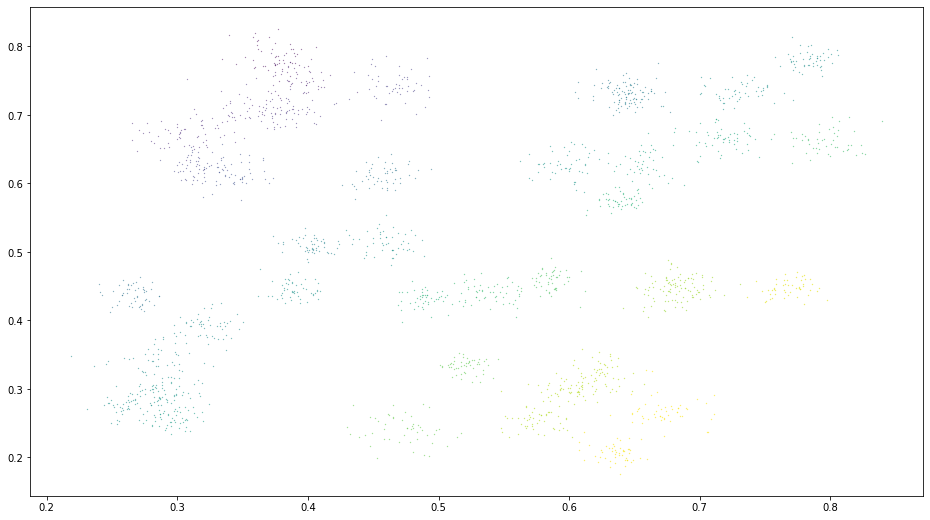

In [ ]:
import matplotlib.cm as cm

def plot_ds(sample_train, target_train):
  min_sample, max_sample = target_train.min(), target_train.max()
  for sample, target in zip(sample_train, target_train):
    r = (target - min_sample) / (max_sample - min_sample)
    color = cm.viridis(r)
    s = jnp.exp(target) / 20
    plt.scatter(sample[:,0], sample[:,1], s=s, color=color)
plot_ds(sample_train, target_train)

In [ ]:
rbf = RBF_Kernel(gamma='auto')
lbda = 1e-2
sinkhorn_epsilon = 1e-2
log_bounds = {'theta': jnp.array(1e-2), 'sigma': jnp.array(1e-2)}, {'theta': jnp.array(1e2), 'sigma': jnp.array(1e2)}
mu_gpr = SinkhornMuGPR(kernel_fun=rbf, debug=False, verbose=True, maxiter=30, log_bounds=log_bounds, lbda=lbda, sinkhorn_epsilon=sinkhorn_epsilon)
gp_params, mu_hist = mu_gpr.optimize_gpr(list(sample_train), list(sample_test), target_train, target_test)

[0] error=9.691 mse=0.000022 loss=-115.578 params={'theta': '1.000', 'sigma': '1.000'} CondNumber=2,078,093,731,183.5
[0.159, 2.149] [0.576, -1.767] [2.549, -1.261] [-1.187, 2.558] [1.140, -0.241]
[1] error=5.352 mse=0.000044 loss=-117.332 params={'sigma': '4.606', 'theta': '0.400'} CondNumber=2,078,101,087,389.0
[0.212, 2.175] [0.511, -1.835] [2.566, -1.238] [-1.199, 2.563] [1.147, -0.224]
[2] error=7.006 mse=0.000039 loss=-117.460 params={'sigma': '4.328', 'theta': '0.459'} CondNumber=131,147,578,705.2
[0.219, 2.148] [0.508, -1.801] [2.530, -1.208] [-1.169, 2.531] [1.136, -0.208]
[3] error=4.868 mse=0.000038 loss=-117.728 params={'sigma': '4.454', 'theta': '0.457'} CondNumber=82,757,451,791.5
[0.226, 2.127] [0.504, -1.776] [2.503, -1.184] [-1.147, 2.506] [1.128, -0.195]
[4] error=3.824 mse=0.000038 loss=-117.847 params={'sigma': '4.518', 'theta': '0.457'} CondNumber=111,842,640,815.5
[0.239, 2.103] [0.494, -1.751] [2.470, -1.153] [-1.120, 2.476] [1.118, -0.177]
[5] error=3.112 mse=0.

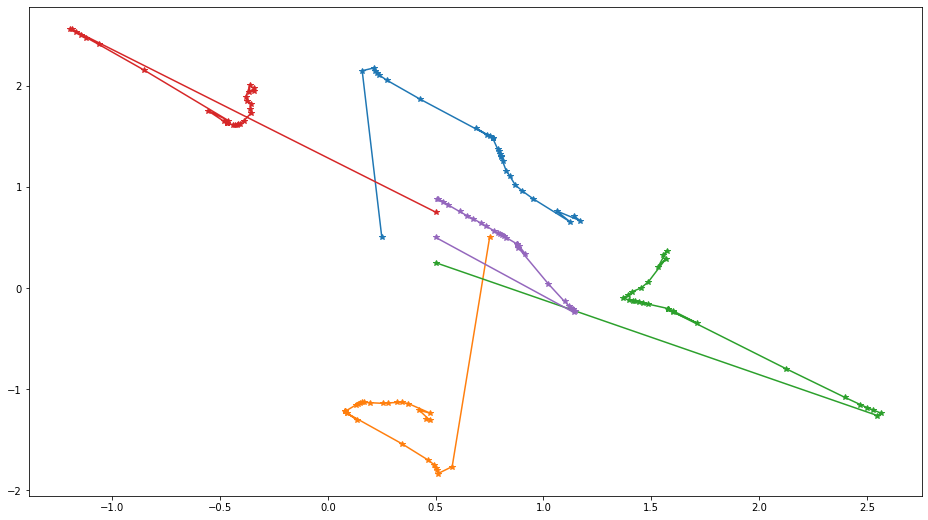

In [ ]:
for i in range(len(mu_hist[0])):
  x = [mu[i,0] for mu in mu_hist]
  y = [mu[i,1] for mu in mu_hist]
  plt.plot(x,y,'-*')

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

X_train = mu_gpr._g_mu(mu_gpr.pad_point_clouds(sample_train), gp_params)
X_test = mu_gpr._g_mu(mu_gpr.pad_point_clouds(sample_test), gp_params)

sk_kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(5e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=10, alpha=lbda**0.5)
gaussian_process.fit(X_train, target_train)
print('Condition number:', jnp.linalg.cond(gaussian_process.kernel_(X_train)))
print('Params:', gaussian_process.kernel_)
onp.set_printoptions(precision=6)
if len(X_train) <= 10:
  print('Kernel:', gaussian_process.kernel_(X_train))
onp.set_printoptions(precision=4)
print('Log Marginal Likelihood:', gaussian_process.log_marginal_likelihood_value_)
test_pred = gaussian_process.predict(X_test)
evs = explained_variance_score(target_test, test_pred)
rmse = mean_squared_error(target_test, test_pred, squared=False)
mae = mean_absolute_error(target_test, test_pred)
msg = f"[SKLEARN] TrainSetSize={len(X_train)} mae={mae:.5f} rmse={rmse:.5f} evs={evs:.5f}"
print(msg)
test_pred = jnp.mean(target_test) * jnp.ones_like(target_test)
evs = explained_variance_score(target_test, test_pred)
rmse = mean_squared_error(target_test, test_pred, squared=False)
mae = mean_absolute_error(target_test, test_pred)
msg = f"[MEAN] TrainSetSize={len(X_train)} mae={mae:.5f} rmse={rmse:.5f} evs={evs:.5f}"
print(msg)

Condition number: 30946298691.93739
Params: 0.402**2 * RBF(length_scale=2.23)
Log Marginal Likelihood: 3.340129642660507
[SKLEARN] TrainSetSize=40 mae=0.04194 rmse=0.05853 evs=0.94016
[MEAN] TrainSetSize=40 mae=0.19332 rmse=0.23865 evs=-0.00000


In [ ]:
Kxx = mu_gpr.kernel_fun(X_train, gp_params['kernel_params'])
print('Condition number:', jnp.linalg.cond(Kxx))
print('Params:', {k: f"{v:.3f}" for k, v in mu_gpr.kernel_fun.get_params(gp_params['kernel_params']).items()})
onp.set_printoptions(precision=6)
if len(Kxx) <= 10:
  print('Kernel:', Kxx)
onp.set_printoptions(precision=4)
print('[JAX    ] Log Marginal Likelihood:', gp_regression_likelihood(Kxx, target_train, lbda=lbda))
print('[SKLEARN] Log Marginal Likelihood:', gp_regression_likelihood(gaussian_process.kernel_(X_train), target_train, lbda=lbda))
delta = jnp.abs(gaussian_process.kernel_(X_train) - Kxx) / gaussian_process.kernel_(X_train)
print(f"Max Rel Error={jnp.max(delta)*100:.2f}%")
test_pred, _ = gp_process_prediction(mu_gpr.kernel_fun, gp_params['kernel_params'], X_train, X_test, target_train, lbda=lbda)
evs = explained_variance_score(target_test, test_pred)
rmse = mean_squared_error(target_test, test_pred, squared=False)
mae = mean_absolute_error(target_test, test_pred)
msg = f"[JAX] TrainSetSize={len(X_train)} mae={mae:.5f} rmse={rmse:.5f} evs={evs:.5f}"
print(msg)

Condition number: 32771967472747.4
Params: {'sigma': '5.581', 'theta': '0.980'}
[JAX    ] Log Marginal Likelihood: 120.61339064270985
[SKLEARN] Log Marginal Likelihood: 115.72334169744468
Max Rel Error=1224.46%
[JAX] TrainSetSize=40 mae=0.00406 rmse=0.00548 evs=0.99947
